In [2]:
import pandas as pd
import numpy as np
import numpy.matlib as nm

from tqdm import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
from scipy.constants import R
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer, RobustScaler
from sklearn.model_selection import ShuffleSplit,KFold,LeaveOneGroupOut

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor

from mp_api.client import MPRester

# 1. Introduction

* The dataset containes 10000 different adsorption sites generated from 626 different intermetallic materials. Each site is feauturized by the information of coordination atoms of the adsorbate and 8 neighbor atoms of the coordination. Each atoms are described by their group number, periodic number, electronegativity and the number of unpaired d electrons.
* a subset of materials is selected by performing the PCA and K-Means Clustering. The materials from cluster 2 is selected based on the observation of systematic variation trend in the property of adsorption energy w.r.t to feature space.
* The LOCO cross-validation folds were defined according the result of K-Means Clustering over the subset selected. 
* the full set of features are used for the regression task
* The goal of this report is to develop a regressor that can predict the adsorption energy of the selected subset of materials from the feature values with a low mean absolute error.

# 2. Coding Section

### 2.0 Importing dataset

In [3]:
df = pd.read_csv('h_data_modelinput.csv').drop(columns=['Unnamed: 0','label','chemsys'])
df.index = range(len(df))
print('# of adsorption sites:', len(df))
print('# of features:', df.shape[1]-3)
print("type of intermetallic materials:",len(df['mpid'].unique()))

# of adsorption sites: 10000
# of features: 51
type of intermetallic materials: 626


In [4]:
df


,mpid,formula,energy,shift,miller,top,0group,0period,0en,0upd,...,9en,9upd,10group,10period,10en,10upd,11group,11period,11en,11upd
0,mp-1281,VIr,-0.306901,0.000000,12,0,9,6,2.20,3,...,1.630000,3.000000,9.000000,6.000000,2.200000,3.000000,5.000000,4.000000,1.630000,3.000000
1,mp-630976,In3Ir,-0.151933,0.051690,2,1,13,5,1.78,0,...,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000
2,mp-22079,AsRh,-0.307631,0.047132,6,1,9,5,2.28,2,...,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966
3,mp-979980,VPd3,0.030970,0.001398,2,0,10,5,2.20,0,...,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000
4,mp-1841,SiIr3,0.571183,0.078788,15,1,9,6,2.20,3,...,2.200000,3.000000,9.000000,6.000000,2.200000,3.000000,9.000000,6.000000,2.200000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,mp-2715,CoAs2,0.173652,0.120513,21,0,9,4,1.88,3,...,1.880000,3.000000,10.068966,4.689655,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966
9996,mp-845,Cu5Sn4,0.031323,0.170213,10,1,11,4,1.90,0,...,1.960000,0.000000,14.000000,5.000000,1.960000,0.000000,14.000000,5.000000,1.960000,0.000000
9997,mp-317,SnRh,-0.330165,0.265130,2,1,9,5,2.28,2,...,2.280000,2.000000,9.000000,5.000000,2.280000,2.000000,14.000000,5.000000,1.960000,0.000000
9998,mp-622209,Al3Ni,-0.020325,0.032621,3,0,13,3,1.61,0,...,1.610000,0.000000,13.000000,3.000000,1.610000,0.000000,13.000000,3.000000,1.610000,0.000000


### 2.1 Clustering and Visualiztion 
PCA analysis and K-means clustering is performed over the whole dataset. Cluster 2 is selected for futher model training as it has some systematic variation that the datapoint with lower PC1&2 are more likely to have a higher target value, and is further confirmed by ploting the target values of the cluster vs the features of top 2 importance('0group' and '1group'), i.e., the target value tends to be higher when the 0group values is higher, especially for 0group $\in$ [4,10]. Same trend is observed between the target value and the 1group feature.

(feature of importance is determined accoriding to its pearson correlation coeff with the target value)


In [5]:
fea = df[list(df.keys())[3:]].to_numpy()     # exclude the first 4 columns "mpid", "formula","energy" that are not numerical features

scaler = StandardScaler()      # standardize the data
fea = scaler.fit_transform(fea)
n_components = fea.shape[-1] 
print("number of components:", n_components)

pca = PCA(n_components)              # calculate the PCs and the explained variance 
pca.fit(fea)                                                 
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(fea)

number of components: 51


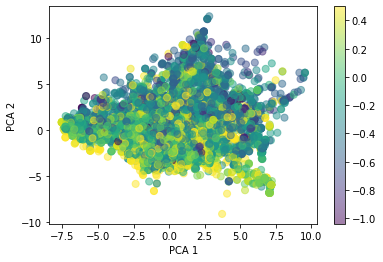

In [6]:
# Visualize the classification of the adsorption sites based on the first two PCs
plt.figure(figsize=(6,4))
# the range of the energy is capped at -1.04 eV and 0.5 eV, to focus more on the dominant & favaorable range
norm = colors.Normalize(vmin=-1.04, vmax=0.5)  
plt.scatter(pos[:,0],pos[:,1],s=50,c = df['energy'],norm=norm, alpha=0.5)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()    

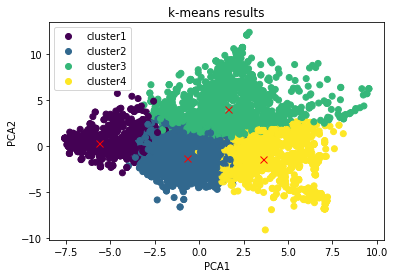

In [8]:
# perform clustering over the PCs
L = kmeans.labels_
k = 4
plt.figure(figsize = (6,4))
kmeans = KMeans(n_clusters=k, random_state =42).fit(pos[:,:20]) 
L = kmeans.labels_
label = []
for i in range(k):                                        # generate label for each cluster
    label.append('cluster'+str(i+1))         
cluster_centers = kmeans.cluster_centers_
plt.subplot(1,1,1)
scatter = plt.scatter(pos[:,0],pos[:,1],c = L)
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'rx', markersize=7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(scatter.legend_elements()[0],label)
plt.title('k-means results')
plt.show()

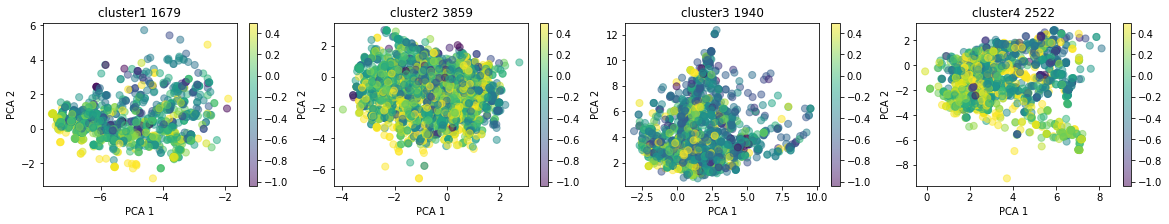

In [9]:
# Visualize target distribution of each cluster based on the first two PCs

plt.figure(figsize=(20,3))

for i in range(k): 
    plt.subplot(1,4,i+1)
    idx = np.where(L==i)[0] # idx of the datapoints for each cluster
    norm = colors.Normalize(vmin=-1.04, vmax=0.5)  # focus more on the dominant & favaorable range
    plt.scatter(pos[idx,0],pos[idx,1],s=50,c = df['energy'].iloc[idx],norm=norm, alpha=0.5)
    plt.colorbar()
    plt.title("cluster"+str(i+1)+' '+str(len(idx)))
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.show()   

3859


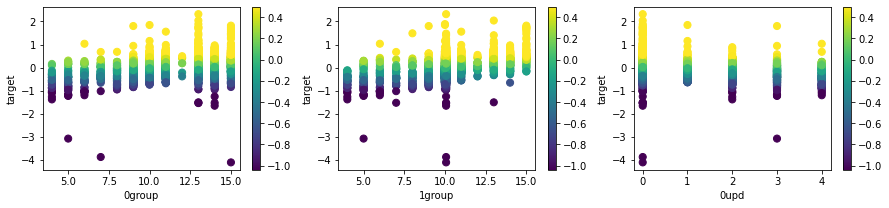

In [10]:
# Visulize the target distribution of the selected cluster (cluster 2) w.r.t. the features
feature = ['0group','1group','0upd']
plt.figure(figsize=(15,3))

idx = np.where(L==1)[0] 
print(len(idx))

for i in range(len(feature)):
    plt.subplot(1,3,i+1)
    plt.scatter(df[feature[i]].iloc[idx],df['energy'].iloc[idx],s=50,norm=norm, c = df['energy'].iloc[idx])
    plt.colorbar()
    plt.xlabel(feature[i])
    plt.ylabel('target')
plt.show()

In [11]:
np.sort(df['0group'].unique())

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int64)

### 2.2 LOCO folds definition
LOCO folds is defined by re-peforming pca analysis and K-meaning clustering over the selected subset

In [12]:
df2 = df.iloc[idx,:]

In [13]:
idx = np.where(L==1)[0] 
fea = df.iloc[idx,3:].to_numpy()     # exclude the first 4 columns "mpid", "formula", "chemsys","energy" that are not numerical features
scaler = StandardScaler()      # standardize the data
fea = scaler.fit_transform(fea)
n_components = fea.shape[-1] 
print("number of components:", n_components)

pca = PCA(n_components)                      # calculate the PCs and the explained variance 
pca.fit(fea)                                                 
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(fea)

number of components: 51


In [14]:
inertias = {}
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pos[:,:20])
    inertias[k] = kmeans.inertia_ 

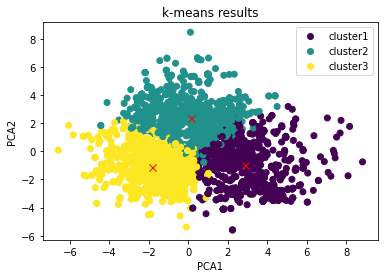

In [15]:
k = 3
PC = [0,1]
plt.figure(figsize = (6,4))
kmeans = KMeans(n_clusters=k, random_state=42).fit(pos) # perform clustering over the PCs
L_2 = kmeans.labels_
label = []
for i in range(k):                                        # generate label for each cluster
    label.append('cluster'+str(i+1))         
cluster_centers = kmeans.cluster_centers_
plt.subplot(1,1,1)
scatter = plt.scatter(pos[:,PC[0]],pos[:,PC[1]], c=L_2)

plt.plot(cluster_centers[:,PC[0]], cluster_centers[:,PC[1]], 'rx', markersize=7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(scatter.legend_elements()[0],label)
plt.title('k-means results')
plt.show()

In [16]:
from sklearn.model_selection import LeaveOneGroupOut
X = df2.iloc[:,3:].to_numpy()
y = df2['energy'].to_numpy()

logo = LeaveOneGroupOut().split(X, y, groups=L_2)
i=0
logo_list=[]
for train_index, test_index in logo:
    print("cluster_leaved:", L_2[test_index][0]+1,"  TRAIN:", len(train_index), "TEST:", len(test_index))
    logo_list.append([train_index,test_index])
    i+=1

cluster_leaved: 1   TRAIN: 2854 TEST: 1005
cluster_leaved: 2   TRAIN: 2656 TEST: 1203
cluster_leaved: 3   TRAIN: 2208 TEST: 1651


### 2.3 Model Fitting

#### 2.3.1 Hyperparameter Tunning

In [18]:
import itertools as it

#define tuning hyperparameters
tuned_hyperpar = {'max_depth': [6,8,10,12,14], 'n_estimators': [50,100,150,200,250]}

# enumerate all combinations of parameters
allpar = sorted(tuned_hyperpar)
combinations = list(it.product(*(tuned_hyperpar[par] for par in allpar)))

In [19]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=40)
R2_mean_list=[]
R2_mean_train_list=[]
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[0]

# define a scoring list
i=0
print("Grid search result")
for com in list(combinations):
    par_dict={}
    count=1
    for par_name in reversed(tuned_hyperpar.keys()):
        par_dict[par_name] = com[len(tuned_hyperpar.keys())-count]
        count+=1
    
    #  use Random CV for every combo of parameters
    group_R2=[]
    group_R2_train=[]

    for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]

        # create a model for every combo
        RFR = RandomForestRegressor(**par_dict)
        #print(par_dict)
        RFR.fit(X_train,y_train)

        #calculate R2 for train set
        y_hat_train = RFR.predict(X_train)
        R2_train = r2_score(y_train, y_hat_train)
        group_R2_train.append(R2_train)

        #calculate R2 for test set
        y_hat = RFR.predict(X_test)
        R2 = r2_score(y_test, y_hat)
        group_R2.append(R2)

    R2_mean_train=np.mean(group_R2_train)
    R2_std_train=np.std(group_R2_train)
    R2_mean_train_list.append(R2_mean_train)

    R2_mean=np.mean(group_R2)
    R2_std=np.std(group_R2)
    R2_mean_list.append(R2_mean)


    print(f"{R2_mean_train:0.3f}(+/-{R2_std_train*2:0.03f}) --> {R2_mean:0.3f} (+/-{R2_std*2:0.03f}) for {par_dict}")
    i+=1

Grid search result
0.634(+/-0.007) --> 0.513 (+/-0.066) for {'n_estimators': 50, 'max_depth': 6}
0.635(+/-0.008) --> 0.515 (+/-0.068) for {'n_estimators': 100, 'max_depth': 6}
0.634(+/-0.009) --> 0.520 (+/-0.050) for {'n_estimators': 150, 'max_depth': 6}
0.636(+/-0.010) --> 0.516 (+/-0.062) for {'n_estimators': 200, 'max_depth': 6}
0.634(+/-0.010) --> 0.519 (+/-0.059) for {'n_estimators': 250, 'max_depth': 6}
0.734(+/-0.014) --> 0.563 (+/-0.056) for {'n_estimators': 50, 'max_depth': 8}
0.733(+/-0.011) --> 0.567 (+/-0.059) for {'n_estimators': 100, 'max_depth': 8}
0.736(+/-0.008) --> 0.567 (+/-0.059) for {'n_estimators': 150, 'max_depth': 8}
0.736(+/-0.011) --> 0.569 (+/-0.054) for {'n_estimators': 200, 'max_depth': 8}
0.735(+/-0.011) --> 0.567 (+/-0.055) for {'n_estimators': 250, 'max_depth': 8}
0.806(+/-0.009) --> 0.607 (+/-0.048) for {'n_estimators': 50, 'max_depth': 10}
0.808(+/-0.008) --> 0.603 (+/-0.057) for {'n_estimators': 100, 'max_depth': 10}
0.810(+/-0.009) --> 0.603 (+/-0.05

In [20]:
# calculate the difference between R2 of test and train set
R2_diff = np.array(R2_mean_train_list)-np.array(R2_mean_list)
print("R2_diff:\n", R2_diff.reshape(5,5))

R2_diff:
 [[0.12091815 0.12054166 0.11468885 0.12033542 0.11541777]
 [0.1704093  0.16582484 0.16877757 0.1671379  0.16819867]
 [0.19893898 0.20425751 0.20681419 0.20564321 0.20311364]
 [0.23387541 0.23227123 0.2324676  0.23404281 0.22962985]
 [0.25321671 0.25097868 0.25179597 0.25166451 0.25217729]]


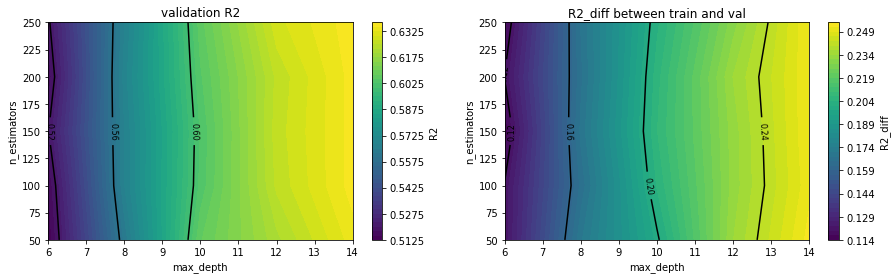

In [21]:
max_depth= tuned_hyperpar['max_depth'] #[6,8,10,12,14]
n_estimators= tuned_hyperpar['n_estimators'] #[50,100,150,200,250]


plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
M, N = np.meshgrid(max_depth, n_estimators)
Z = np.array(R2_mean_list).reshape(5,5).transpose()
plt.contourf(M, N, Z, 50, )
plt.colorbar(label='R2');
 
contours = plt.contour(M,N, Z, 3,colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('validation R2')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
#-----------------------------------------------------
plt.subplot(1,2,2)
M, N = np.meshgrid(max_depth, n_estimators)
Z = np.array(R2_diff).reshape(5,5).transpose()
plt.contourf(M,N, Z, 50,)
plt.colorbar(label='R2_diff')
 
contours = plt.contour(M,N, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('R2_diff between train and val')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

plt.show()

#### 2.3.2 Model Validation
A final hyperparameter of {'max_depth': 12, 'n_estimators': 150} is selected and the model performance is validated by performing random-CV and LOCO-CV. The compasion of the two CV methods is shown in the **CV Summary** section below

In [27]:
par_dict_final={'max_depth': 12, 'n_estimators': 150}

##### Random-CV

In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=36)

group_R2_train = []
group_R2 = []
y_hat_randCV = np.zeros(len(y))-1
std_randCV = np.zeros(len(y))-1
len_count = 0

for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]

        # create a model for using tuned hyperparameters
        RFR_rd = RandomForestRegressor(**par_dict_final)
        #print(par_dict)
        RFR_rd.fit(X_train,y_train)

        #calculate R2 for train set
        y_hat_train = RFR_rd.predict(X_train)
        R2_train = r2_score(y_train, y_hat_train)
        group_R2_train.append(R2_train)

        #calculate R2 for test set
        y_hat = RFR_rd.predict(X_test)
        R2 = r2_score(y_test, y_hat)
        group_R2.append(R2)

        # store the predicted value
        std_randCV[test_index] = np.std([tree.predict(X_test) for tree in RFR_rd.estimators_], axis=0)
        y_hat_randCV[test_index] = y_hat
        len_count += len(test_index)

print(len(df2)==len_count)
print(f"{[f'{val:.3f}' for val in group_R2]}")

True
['0.624', '0.545', '0.589', '0.593', '0.520']


##### LOCO-CV

In [31]:
group_R2_train_LOCO = []
group_R2_LOCO = []
y_hat_LOCO = np.zeros(len(y))-1
std_LOCO = np.zeros(len(y))-1
len_count = 0
for train_index, test_index in logo_list:
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]

        # create a model for using tuned hyperparameters
        RFR_LOCO = RandomForestRegressor(**par_dict_final)
        #print(par_dict)
        RFR_LOCO.fit(X_train,y_train)

        #calculate R2 for train set
        y_hat_train = RFR_LOCO.predict(X_train)
        R2_train = r2_score(y_train, y_hat_train)
        group_R2_train_LOCO.append(R2_train)

        #calculate R2 for test set
        y_hat = RFR_LOCO.predict(X_test)
        R2 = r2_score(y_test, y_hat)
        group_R2_LOCO.append(R2)

        # store the predicted value
        std_LOCO[test_index] = np.std([tree.predict(X_test) for tree in RFR_LOCO.estimators_], axis=0)
        y_hat_LOCO[test_index] = y_hat
        len_count += len(test_index)

print(len(df2)==len_count)
print(f"{[f'{val:.3f}' for val in group_R2_LOCO]}")

True
['0.276', '0.408', '0.415']


##### CV Summary
The general trend observed is that, with approximately same training R2, the random-CV generally have a higher validation R2 than the LOCO-CV, which is expected as 
1. The random-CV is more robust to the noise in the dataset.
2. According to visualiztion of the LOCO clustering results, each cluster tends to have a relatively seperated feature space, and could contain the feature-target relation that does not exist in the other clusters, thus cannot be captured upon training.(simlilar to reason 1.)
3. The train-validation ratio is much lower for the LOCO-CV, less data is used for training to allow the model capture the overall feature-target relationship, the overfitting issue is more likely to occur.

The specific trend observed is that CV score for leave cluster 1 one is much lower than the other 2 LOCO CV. As displayed in the Visualiztion of the LOCO clustering results in the target-feature plots, the data point of cluster 1 are mostly having a feature value that is poorly correlated with the target value. I.e., for feature 0group, the target value distribtions are about proportional with 0group $\in$ [4,10], even a bit for [14,15], while the cluster 1 data points mostly have 0group = 13, where the target distrbution bascially span the whole feature value range, and therefore is expected to have a low R2 score. Similar issue can be observed from the plots of 1group-target and 2group-target.


Removing those data points that have a widespreading target values with the same feature value could be a potential way to improve the model performance.

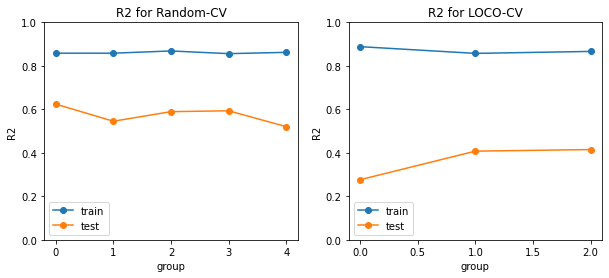

In [32]:
# plot group R2 of random-CV for train and test set in the same figure
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(group_R2_train, 'o-', label='train')
plt.plot(group_R2, 'o-', label='test')
plt.legend()
plt.title('R2 for Random-CV')
plt.xlabel('group')
plt.ylabel('R2')
plt.ylim(0,1)

# plot group R2 of LOCO-CV for train and test set in the same figure
plt.subplot(1,2,2)
plt.plot(group_R2_train_LOCO, 'o-', label='train')
plt.plot(group_R2_LOCO, 'o-', label='test') 
plt.legend()
plt.title('R2 for LOCO-CV')
plt.xlabel('group')
plt.ylabel('R2')
plt.ylim(0,1)
plt.show()



3859


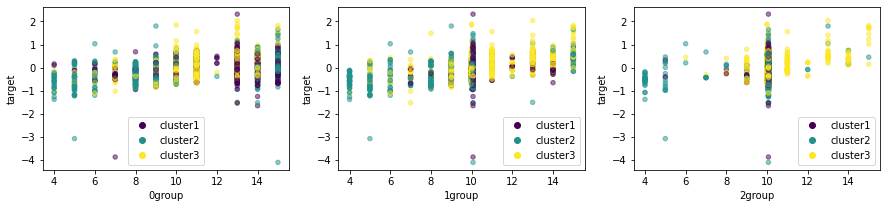

In [36]:
# Visualiztion of the LOCO clustering results in the target-feature plots
feature = ['0group','1group','2group']
plt.figure(figsize=(15,3))

idx = np.where(L==1)[0] 
print(len(idx))

label = [] # generate label for each cluster
for i in range(k):                                       
    label.append('cluster'+str(i+1))         
cluster_centers = kmeans.cluster_centers_

for i in range(len(feature)):
    plt.subplot(1,3,i+1)
    plt.scatter(df[feature[i]].iloc[idx],df['energy'].iloc[idx],c=L_2,s=20,alpha=0.5)
    plt.legend(scatter.legend_elements()[0],label)
    plt.xlabel(feature[i])
    plt.ylabel('target')
plt.show()

#### 2.3.3 Train a full data model

In [43]:
RFR_full = RandomForestRegressor(**par_dict_final)
print(par_dict_final)
RFR_full.fit(X,y)

#calculate R2 for train set
y_hat = RFR_full.predict(X)
R2 = r2_score(y, y_hat)
std = np.std([tree.predict(X) for tree in RFR_full.estimators_], axis=0)
print(R2)


{'max_depth': 12, 'n_estimators': 150}
0.8543332991464871


### 2.4 Model Evaluation

The MSE/MAPE/MAE value for the random CV models, LOCO CV models and the full data model are displayed below. Parity plot is also shown for each model. 
The overall predicitve performance is as expected: full data model> random CV> LOCO CV. Since the full data model is tested on the same dataset that it have already seen, it would be expected to have a better performance than the random CV/LOCO CV models. 
Both CV failed to predict those outlier values. 

Suprisingly, in the case of LOCO-CV, I was expecting the outlier values from cluster 1 to be predicted better as the model is trained on the data points with the other 2 outliers where one of them actually have a similar feature value as the cluster 1 outlier.Futher increasing the expressive power of model(increase the max_depth) could be a potential way to capture this outlier value (at cost of worse overfitting).

In [37]:
print('---------random CV---------')
mse = mean_squared_error(y, y_hat_randCV)
mape = mean_absolute_percentage_error(y, y_hat_randCV)
mae = mean_absolute_error(y, y_hat_randCV)
print(f"mse: {mse:.3f}, mape: {mape:.3f}, mae: {mae:.3f}",'\n')

print('---------LOCO CV---------')
mse = mean_squared_error(y, y_hat_LOCO)
mape = mean_absolute_percentage_error(y, y_hat_LOCO)
mae = mean_absolute_error(y, y_hat_LOCO)
print(f"mse: {mse:.3f}, mape: {mape:.3f}, mae: {mae:.3f}",'\n')

print('---------full model---------')
mse = mean_squared_error(y, y_hat)
mape = mean_absolute_percentage_error(y, y_hat)
mae = mean_absolute_error(y, y_hat)
print(f"mse: {mse:.3f}, mape: {mape:.3f}, mae: {mae:.3f}")

---------random CV---------
mse: 0.070, mape: 1.591, mae: 0.164 

---------LOCO CV---------
mse: 0.099, mape: 2.493, mae: 0.223 

---------full model---------
mse: 0.024, mape: 1.152, mae: 0.107


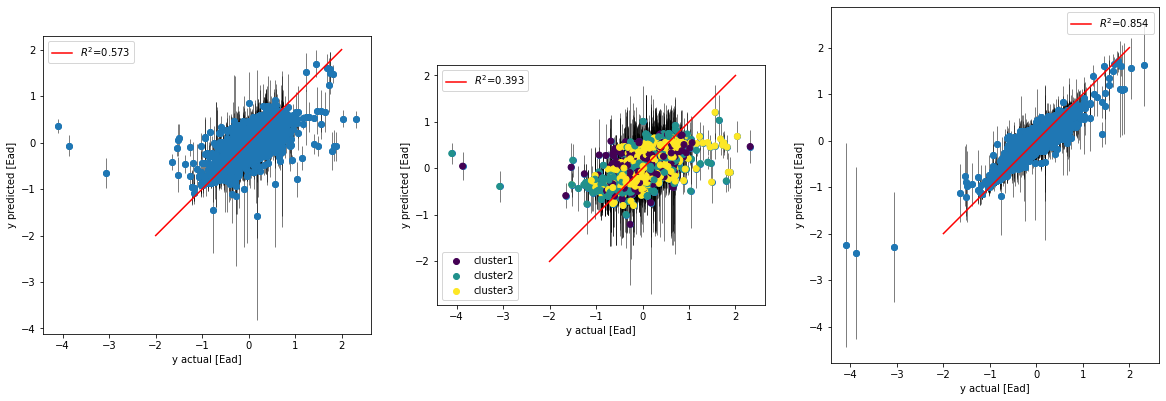

In [74]:
plt.figure(figsize=(20,15))
###-----------------parity plot for random CV-----------------###
plt.subplot(1,3,1)
plt.scatter(y, y_hat_randCV, zorder=10)
plt.xlabel('y actual [Ead]')
plt.ylabel('y predicted [Ead]')

plt.errorbar(y, y_hat_randCV, yerr=std_randCV, fmt='o', ecolor='k', zorder=0, elinewidth=0.5) # plot error bar

plt.plot([-2,2],[-2,2], c='r', label='$R^{2}$='+ str(round(r2_score(y, y_hat_randCV),3)), zorder=20) # plot a line with the slope of 1

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')

###-----------------parity plot for LOCO CV-----------------###
plt.subplot(1,3,2)
scatter = plt.scatter(y, y_hat_LOCO, c=L_2, zorder=10)

label = []
for i in range(k):                                        # generate label for each cluster
    label.append('cluster'+str(i+1)) 
# add an extra legend for the cluster using matplotlib.patches.Patch
legend1 = plt.legend(scatter.legend_elements()[0],label, loc="lower left")
plt.gca().add_artist(legend1)

plt.xlabel('y actual [Ead]')
plt.ylabel('y predicted [Ead]')

plt.errorbar(y, y_hat_LOCO, yerr=std_LOCO, fmt='o', ecolor='k', zorder=0, elinewidth=0.5) # plot error bar

plt.plot([-2,2],[-2,2], c='r', label='$R^{2}$='+ str(round(r2_score(y, y_hat_LOCO),3)), zorder=20) # plot a line with the slope of 1
legend2 = plt.legend(loc=2)


plt.gca().set_aspect('equal', adjustable='box')

###-----------------parity plot for full dataset-----------------###
plt.subplot(1,3,3)
plt.scatter(y, y_hat, zorder=10)
plt.xlabel('y actual [Ead]')
plt.ylabel('y predicted [Ead]')

plt.errorbar(y, y_hat, yerr=std, fmt='o', ecolor='k', zorder=0, elinewidth=0.5) # plot error bar

plt.plot([-2,2],[-2,2], c='r', label='$R^{2}$='+ str(round(r2_score(y, y_hat),3)), zorder=20) # plot a line with the slope of 1

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')


#### 2.5 Feature Importance

Feature: 0, Score: 0.07645
Feature: 1, Score: 0.03541
Feature: 2, Score: 0.00805
Feature: 3, Score: 0.20377
Feature: 4, Score: 0.12298
Feature: 5, Score: 0.01394
Feature: 6, Score: 0.01870
Feature: 7, Score: 0.12695
Feature: 8, Score: 0.01978
Feature: 9, Score: 0.02314


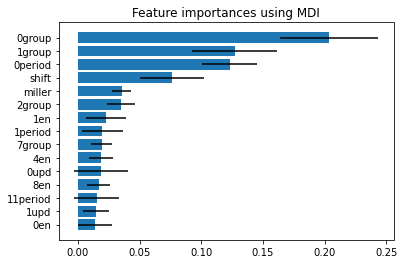

In [75]:
# get importance
importance = RFR_full.fit(X,y).feature_importances_ #using Gini importance implemented by Sklearn (Mean decrease in impurity)
std = np.std([tree.feature_importances_ for tree in RFR_full.estimators_], axis=0)

# plot feature importance
sort = importance.argsort()[-15:]
#reverse sort
plt.barh(df2.iloc[:,3:].columns[sort], importance[sort], xerr=std[sort])

plt.title("Feature importances using MDI")

# summarize feature importance
for i,v in enumerate(importance[:10]):
    print('Feature: %0d, Score: %.5f' % (i,v))

# 3.Summary

The random forest regressor have displayed an overall fair predictive capability, given the inherent noise in the dataset. The mean abosolute error for the random CV model, LOCO-CV model and the full data model are 0.164,0.226,0.108 respectively, which is still a bit high for the target value range of [-2,1]. 

According to the grid search map, the current model is already overfitting a lot, since a relatively high max_depth value is selected disgarding the increasing difference between the training and validation R2 score, just as a trade-off for better validation accuracy. Removing the outlier data points and noise could be a potential way to improve the model performance and reduce the overfitting issue. 

The top 3 feature of importance make perfect physical sense, since the property of the nearest neighbor are apparently having more determenistic effect on the adsorption energy for Hydrogen. (group referres to the group number of an element, 0 is the neartest neighbor, 1 is the second nearest neighbor, etc.) However, the rank of 0upd and 1 upd, which refers to the un-paired d-orbital electrons of an atom, are much lower than expected given that they have a quite high pearson correlation coeff with the target value just as 0group and 1group. The 0upd even have a very high std among the tree predictors. This could be asscoiated with 1. the noise data points 2. the correlation relation are stronger for those data with non-zero 0upd/1upd, and got misleading by the crowd of 0upd/1upd = 0 data points.
 